In [89]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
import random

In [90]:
def neighbor_edges_of_node(graph, node):
    neighbor_edges = []
    for edge in graph.edges():
        if node in edge:
            neighbor_edges.append(edge)
    return neighbor_edges

In [91]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [92]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph

In [93]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [94]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):

    print(coloring_result)
    with open('./results/ga_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        if coloring_result == -1:
            result_file.write("Time limit exceeded.\n")
            print("Time limit exceeded.\n")
        else:
            if coloring_result:
                result_file.write("Minimum edge coloring found.\n")
                result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
                result_file.write(f"Number of iterations: {iter}\n")

                print("Minimum edge coloring found.")
                print("Number of colors:", len(set(coloring_result)))  
                print("Number of iterations:", iter)
                draw_colored_graph(graph, coloring_result)
                plt.close() 
            else:
                result_file.write("No solution found.\n")
                print("No solution found.\n") 

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [95]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts = [int(part) if part.isdigit() else part for part in parts]
    return parts

In [96]:
def is_feasible(solution):
    return any(solution)

In [97]:
class Individual:
    def __init__(self, graph):
        self.graph = graph  
        self.num_of_edges = len(graph.edges())
        self.coloring = [random.randrange(1, len(graph.edges())) for _ in range(len(graph.edges()))]
        self.fitness = self.calc_fitness()  

    
    def calc_fitness(self):
        graph = self.graph
        edge_color = {edge: self.coloring[i] for i, edge in enumerate(graph.edges())}
        num = 0
    
        for edge in graph.edges():
            indicator = True
    
            u, v = edge
            
            u_edges = neighbor_edges_of_node(graph, u)
            v_edges = neighbor_edges_of_node(graph, v)
    
            u_edges.remove(edge)
            v_edges.remove(edge)
            
            for i in range(len(u_edges)):
                if edge_color[u_edges[i]] == edge_color[edge]:
                    indicator = False
            
            for j in range(len(v_edges)):  
                if edge_color[v_edges[j]] == edge_color[edge]:
                    indicator = False
    
            if indicator:
                num += 1

        if is_valid_coloring(graph,self.coloring):
            return len(graph.edges()) - num
        else:
            return -100


In [98]:
def selection(population, tournament_size):
    chosen = random.sample(population, tournament_size)
    return max(chosen, key=lambda x: x.fitness)

In [99]:
def crossover(parent1, parent2, child1, child2):
    random_pos = random.randrange(0, len(parent1.coloring))
    
    child1.coloring[:random_pos] = parent1.coloring[:random_pos]
    child1.coloring[random_pos:] = parent2.coloring[random_pos:]
    
    child2.coloring[:random_pos] = parent2.coloring[:random_pos]
    child2.coloring[random_pos:] = parent1.coloring[random_pos:]

In [100]:
def mutation(individual, mutation_prob):
    for i in range(len(individual.coloring)):
        if random.random() < mutation_prob:
            new_color = random.randrange(1, individual.num_of_edges)
            while new_color == individual.coloring[i]:
                new_color = random.randrange(1, individual.num_of_edges)
            individual.coloring[i] = new_color

In [101]:
def genetic_algorithm(graph, population_size, num_generations, tournament_size, elitism_size, mutation_prob):

    population = [Individual(graph) for _ in range(population_size)]
    new_population = population.copy()

    for i in range(num_generations):
        population.sort(key=lambda x: x.fitness, reverse=True)
        new_population[:elitism_size] = population[:elitism_size]
        
        for j in range(elitism_size, population_size, 2):
            parent1 = selection(population, tournament_size)
            parent2 = selection(population, tournament_size) 
            
            crossover(parent1, parent2, child1=new_population[j], child2=new_population[j+1])

            mutation(new_population[j], mutation_prob)
            mutation(new_population[j+1], mutation_prob)
            
            new_population[j].fitness = new_population[j].calc_fitness()
            new_population[j+1].fitness = new_population[j+1].calc_fitness()
        
        population = new_population.copy()
        
        best_individual = max(population, key=lambda x: x.fitness)

        idx = population.index(best_individual)

        if is_valid_coloring(graph, best_individual.coloring):
            return best_individual, idx
        else:
            return -100, -100


In [102]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")

            start_time = time.time()
            graph = read_graph_from_file(filepath)
            best_individual, index = genetic_algorithm(graph, 
                                                population_size=100,
                                                num_generations=10,
                                                tournament_size=7,
                                                elitism_size=10,
                                                mutation_prob=0.05)
            end_time = time.time()

            if best_individual == -100:
                write_output(graph, file, None, index, start_time, end_time)
            else:
                write_output(graph, file, best_individual.coloring, index, start_time, end_time)     

Running test graph_3_edges.txt...
None
No solution found.

Time taken: 0.015806198120117188 seconds

Running test graph_5_edges.txt...
[1, 3, 4, 3, 2]
Minimum edge coloring found.
Number of colors: 4
Number of iterations: 0


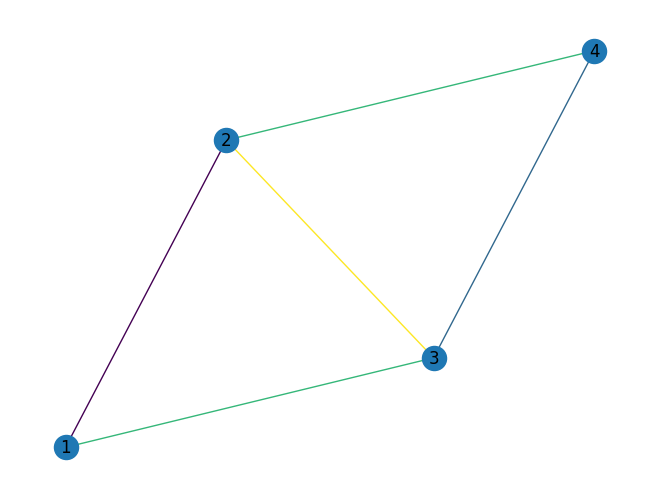

Time taken: 0.03202509880065918 seconds

Running test graph_5_edges_2.txt...
[3, 4, 1, 2, 3]
Minimum edge coloring found.
Number of colors: 4
Number of iterations: 0


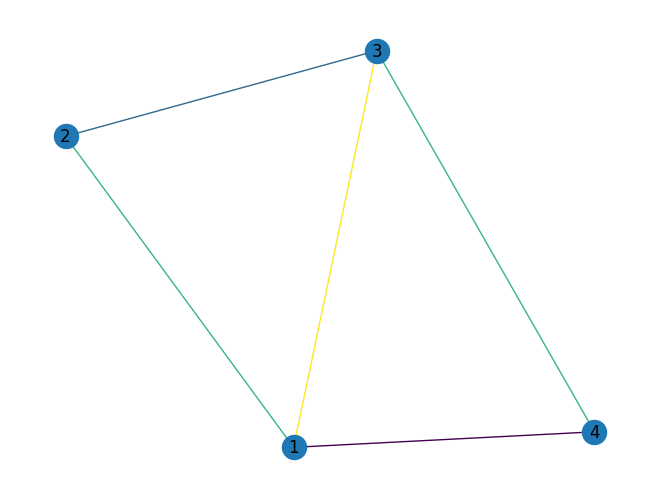

Time taken: 0.03414416313171387 seconds

Running test graph_6_edges.txt...
[5, 3, 2, 4, 2, 3]
Minimum edge coloring found.
Number of colors: 4
Number of iterations: 3


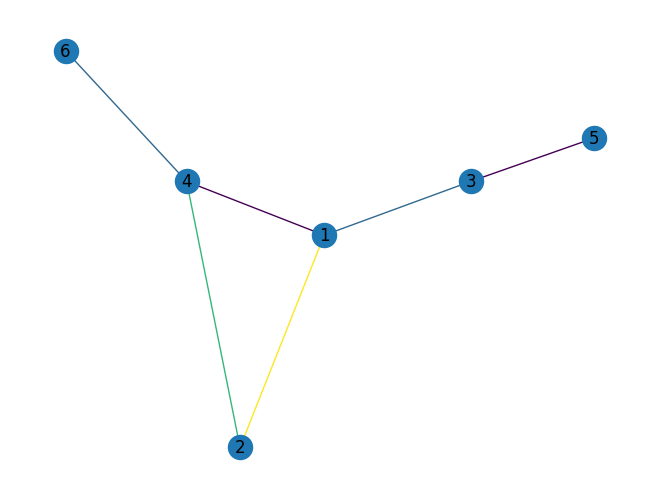

Time taken: 0.032724857330322266 seconds

Running test graph_7_edges.txt...
[4, 6, 3, 2, 1, 5, 6]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 0


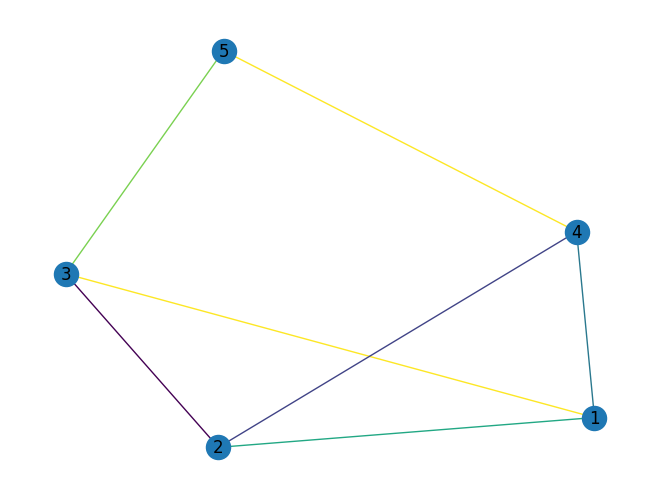

Time taken: 0.07937788963317871 seconds

Running test graph_7_edges_2.txt...
[5, 6, 4, 2, 6, 4, 2]
Minimum edge coloring found.
Number of colors: 4
Number of iterations: 0


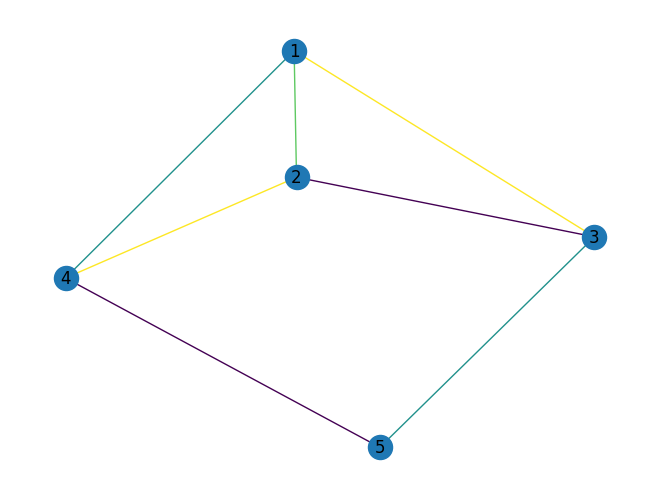

Time taken: 0.03048992156982422 seconds

Running test graph_7_edges_3.txt...
[6, 5, 2, 4, 1, 6, 1]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 0


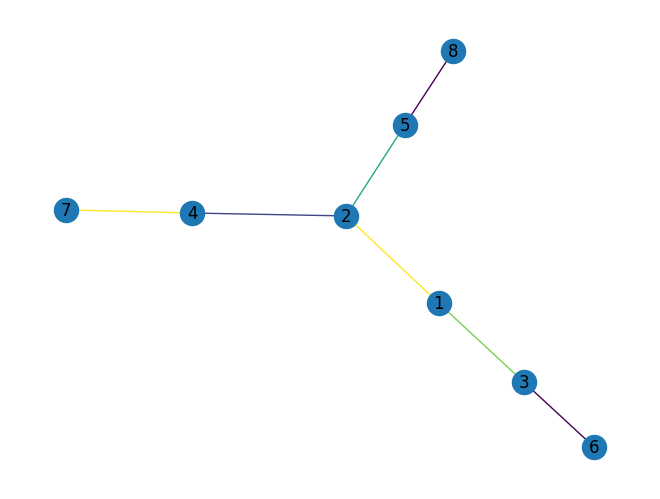

Time taken: 0.03804492950439453 seconds

Running test graph_8_edges.txt...
[5, 7, 2, 4, 1, 2, 4, 4]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 0


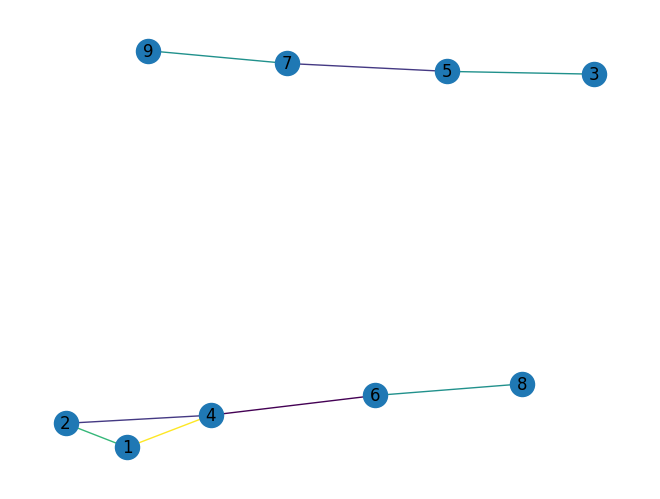

Time taken: 0.06914520263671875 seconds

Running test graph_9_edges.txt...
[3, 4, 1, 4, 3, 6, 8, 8, 7]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 0


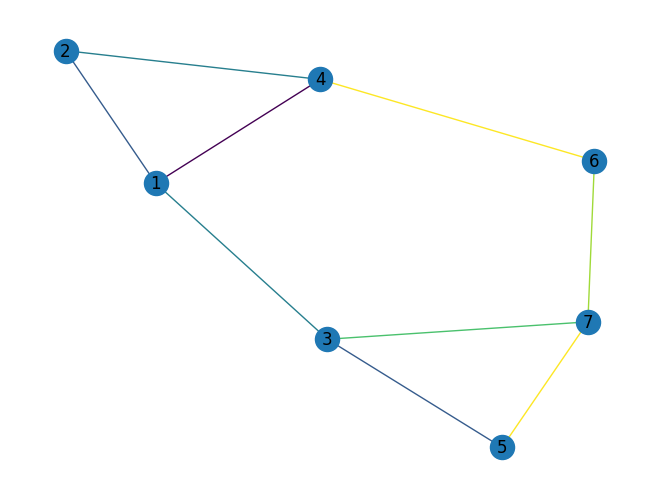

Time taken: 0.04831385612487793 seconds

Running test graph_9_edges_2.txt...
[1, 4, 5, 7, 5, 3, 3, 1, 4]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 0


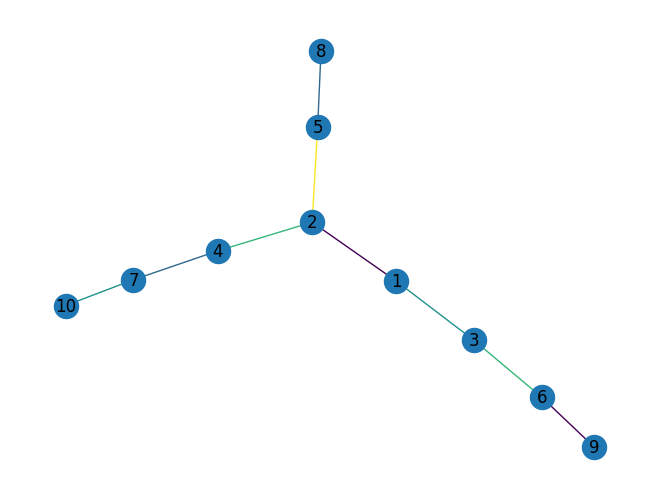

Time taken: 0.08989357948303223 seconds

Running test graph_10_edges.txt...
[1, 6, 6, 9, 2, 2, 2, 9, 5, 5]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 0


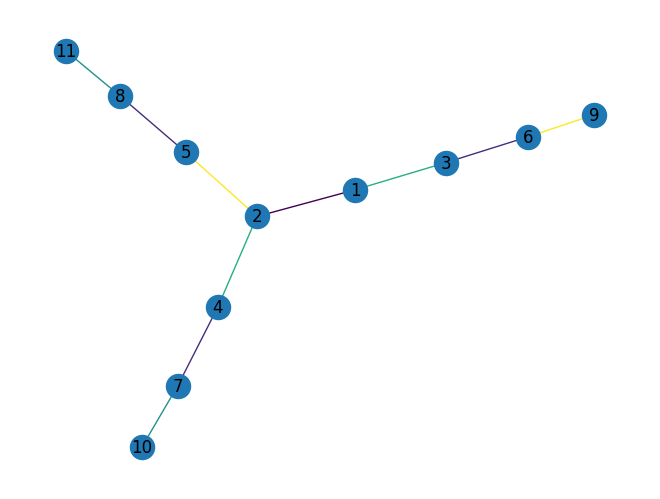

Time taken: 0.11066889762878418 seconds

Running test graph_10_edges_2.txt...
[2, 4, 5, 6, 5, 7, 3, 6, 1, 9]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 4


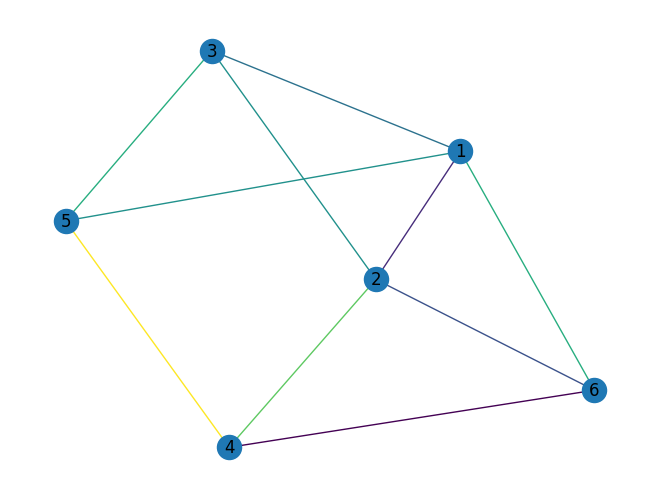

Time taken: 0.06883668899536133 seconds

Running test graph_10_edges_3.txt...
[4, 8, 2, 6, 7, 5, 3, 2, 8, 7]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 0


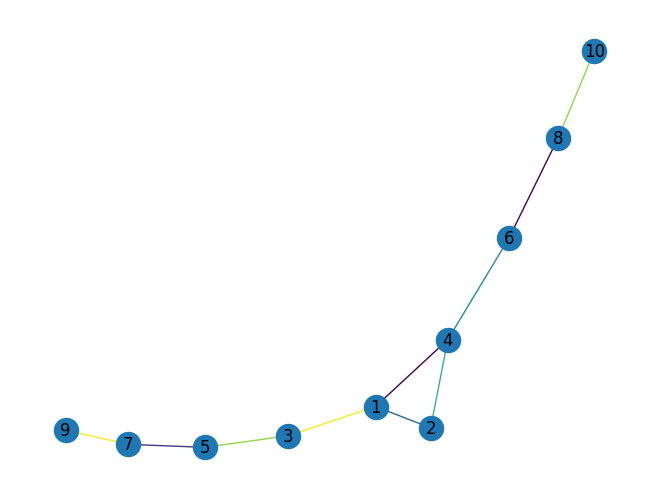

Time taken: 0.06752800941467285 seconds

Running test graph_11_edges.txt...
[2, 5, 8, 5, 8, 9, 3, 6, 8, 6, 1]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 0


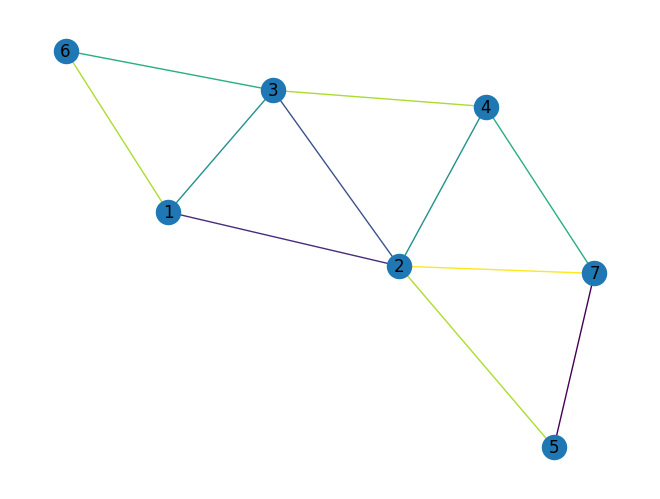

Time taken: 0.0532374382019043 seconds

Running test graph_11_edges_2s.txt...
[1, 7, 4, 9, 8, 3, 9, 10, 6, 10, 4]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 0


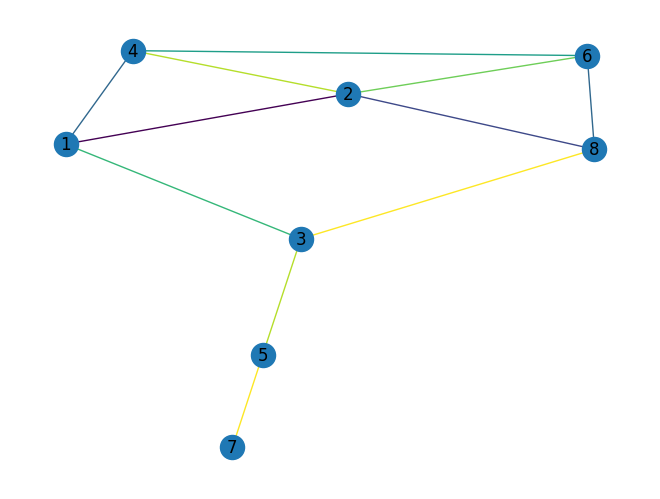

Time taken: 0.0680990219116211 seconds

Running test graph_11_edges_3.txt...
[4, 5, 10, 6, 4, 1, 3, 2, 10, 10, 7]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 0


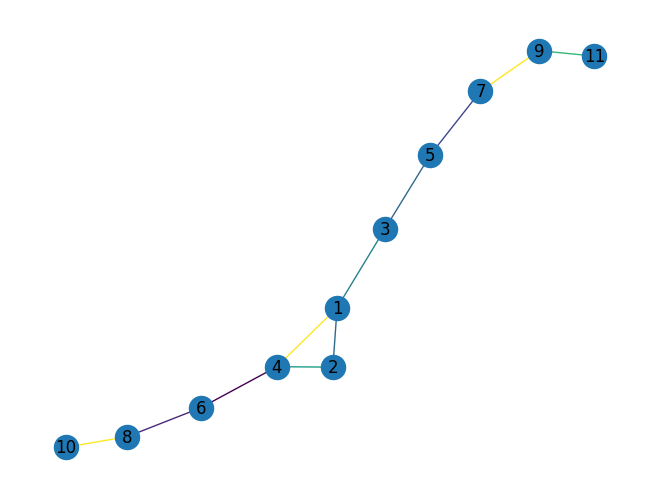

Time taken: 0.0951545238494873 seconds

Running test graph_11_edges_4.txt...
[6, 9, 4, 10, 2, 2, 4, 9, 4, 9, 6]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 0


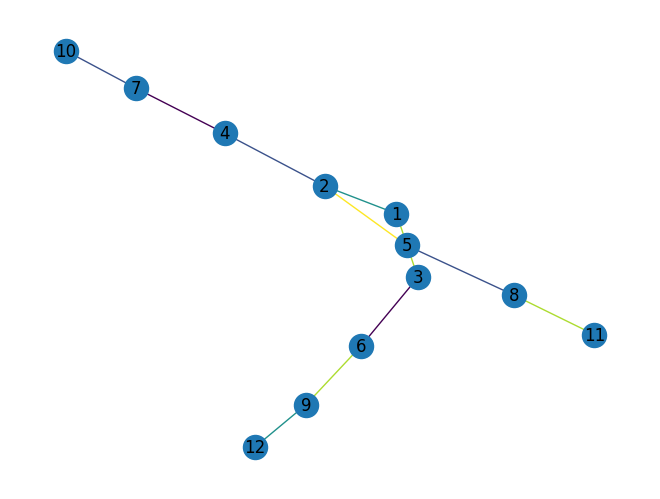

Time taken: 0.10997557640075684 seconds

Running test graph_12_edges.txt...
[11, 1, 9, 5, 11, 11, 2, 8, 7, 2, 10, 3]
Minimum edge coloring found.
Number of colors: 9
Number of iterations: 0


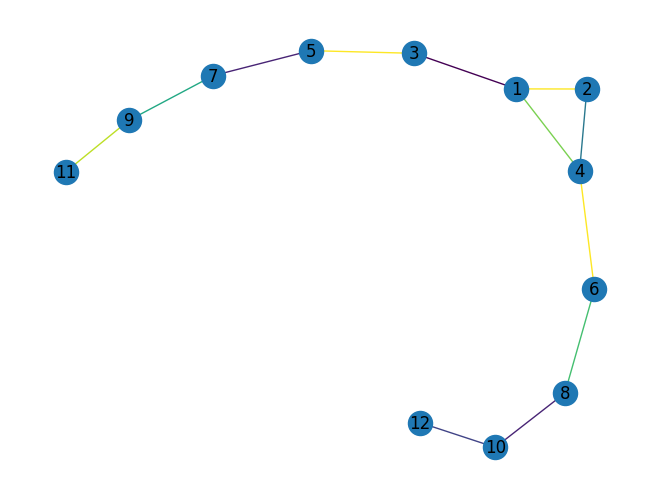

Time taken: 0.08227753639221191 seconds

Running test graph_12_edges_2.txt...
[1, 2, 6, 5, 9, 11, 3, 2, 5, 1, 1, 9]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 0


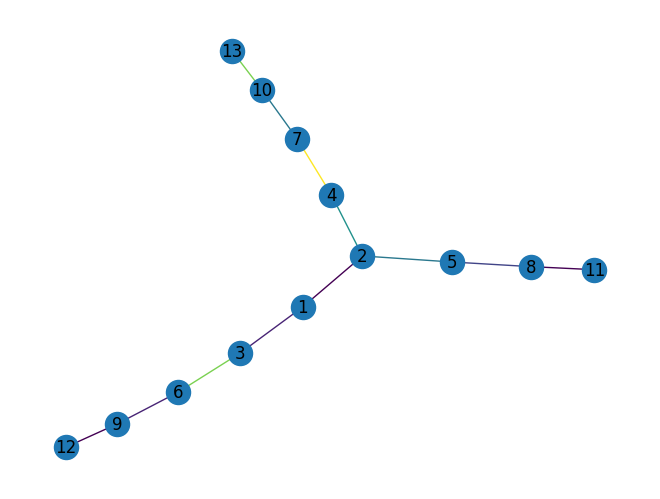

Time taken: 0.07977509498596191 seconds

Running test graph_15_edges.txt...
[14, 7, 12, 9, 5, 10, 12, 10, 2, 14, 9, 6, 4, 1, 9]
Minimum edge coloring found.
Number of colors: 10
Number of iterations: 1


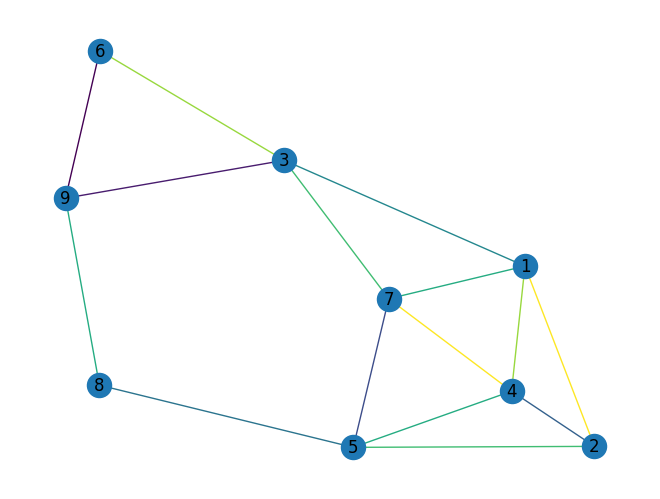

Time taken: 0.07965350151062012 seconds



In [103]:
with open('./results/ga_results.txt', 'w') as result_file:
    result_file.write("")

run_tests('./tests')